In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [3]:
#import jax
#jax.config.update('jax_platform_name', 'cpu')

In [4]:
from entot.data.data import create_gaussians, create_gaussian_split
from entot.plotting.plots import plot_1D, plot_1D_unbalanced
from entot.models.models import NoiseOutsourcingModel, KantorovichGapModel
from entot.models.utils import MixtureNormalSampler, Simple_MLP
import matplotlib.pyplot as plt
import numpy as np
import jax
import jax.numpy as jnp

2023-06-14 16:57:18.830867: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [5]:
sampler_source = MixtureNormalSampler([-1,0.0,2.0], 1,  0.1, batch_size=512)
sampler_target = MixtureNormalSampler([0.0], 1,  0.2, batch_size=512)

In [6]:
source = sampler_source(jax.random.PRNGKey(0))
target = sampler_target(jax.random.PRNGKey(0))

In [7]:
from ott.solvers.linear import sinkhorn
from ott.problems.linear import linear_problem
from ott.geometry.pointcloud import PointCloud

In [8]:
source=source.sort(axis=0)
target =target.sort(axis=0)

In [9]:
geom = PointCloud(source, target, epsilon=1e-3)

In [10]:
sinkhorn_output_unbalanced = sinkhorn.Sinkhorn()(
            linear_problem.LinearProblem(geom, tau_a=0.998, tau_b=0.998)
        )

sinkhorn_output_balanced = sinkhorn.Sinkhorn()(
        linear_problem.LinearProblem(geom, tau_a=1.0, tau_b=1.0)
    )

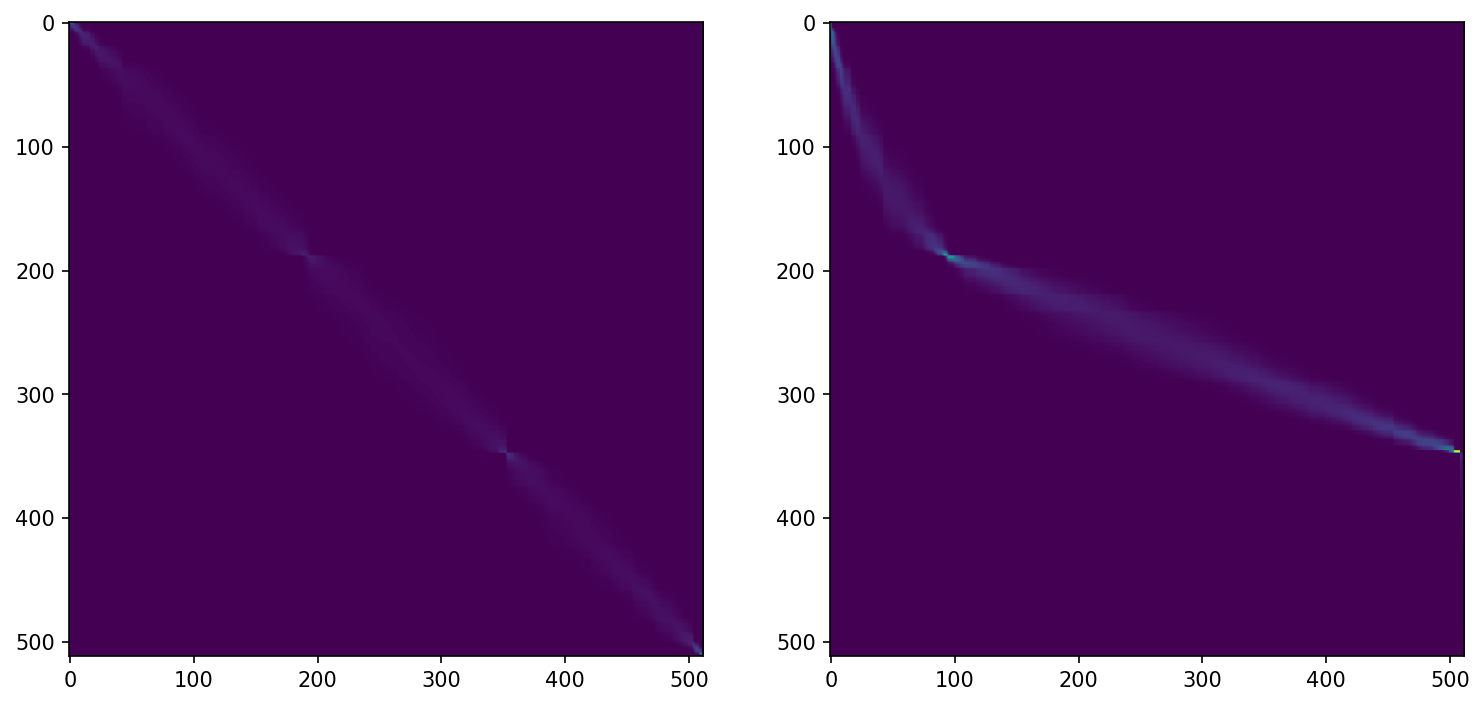

In [11]:
fig, axes = plt.subplots(1,2, figsize=(12, 8), dpi=150)
axes[0].imshow(sinkhorn_output_balanced.matrix)
axes[1].imshow(sinkhorn_output_unbalanced.matrix)

In [12]:
import pandas as pd
from entot.models.utils import _concatenate
pi_star_inds = jax.random.categorical(jax.random.PRNGKey(0), logits=jnp.log(sinkhorn_output_unbalanced.matrix.flatten()), shape=(len(source),))
inds_source = pi_star_inds // len(target)
inds_target = pi_star_inds % len(target)
data = _concatenate(source[inds_source], target[inds_target])
gt_unbalanced = pd.DataFrame(data = data, columns=["source", "target"])

pi_star_inds = jax.random.categorical(jax.random.PRNGKey(0), logits=jnp.log(sinkhorn_output_balanced.matrix.flatten()), shape=(len(source),))
inds_source = pi_star_inds // len(target)
inds_target = pi_star_inds % len(target)
data = _concatenate(source[inds_source], target[inds_target])
gt_balanced = pd.DataFrame(data = data, columns=["source", "target"])

<Axes: xlabel='source', ylabel='target'>

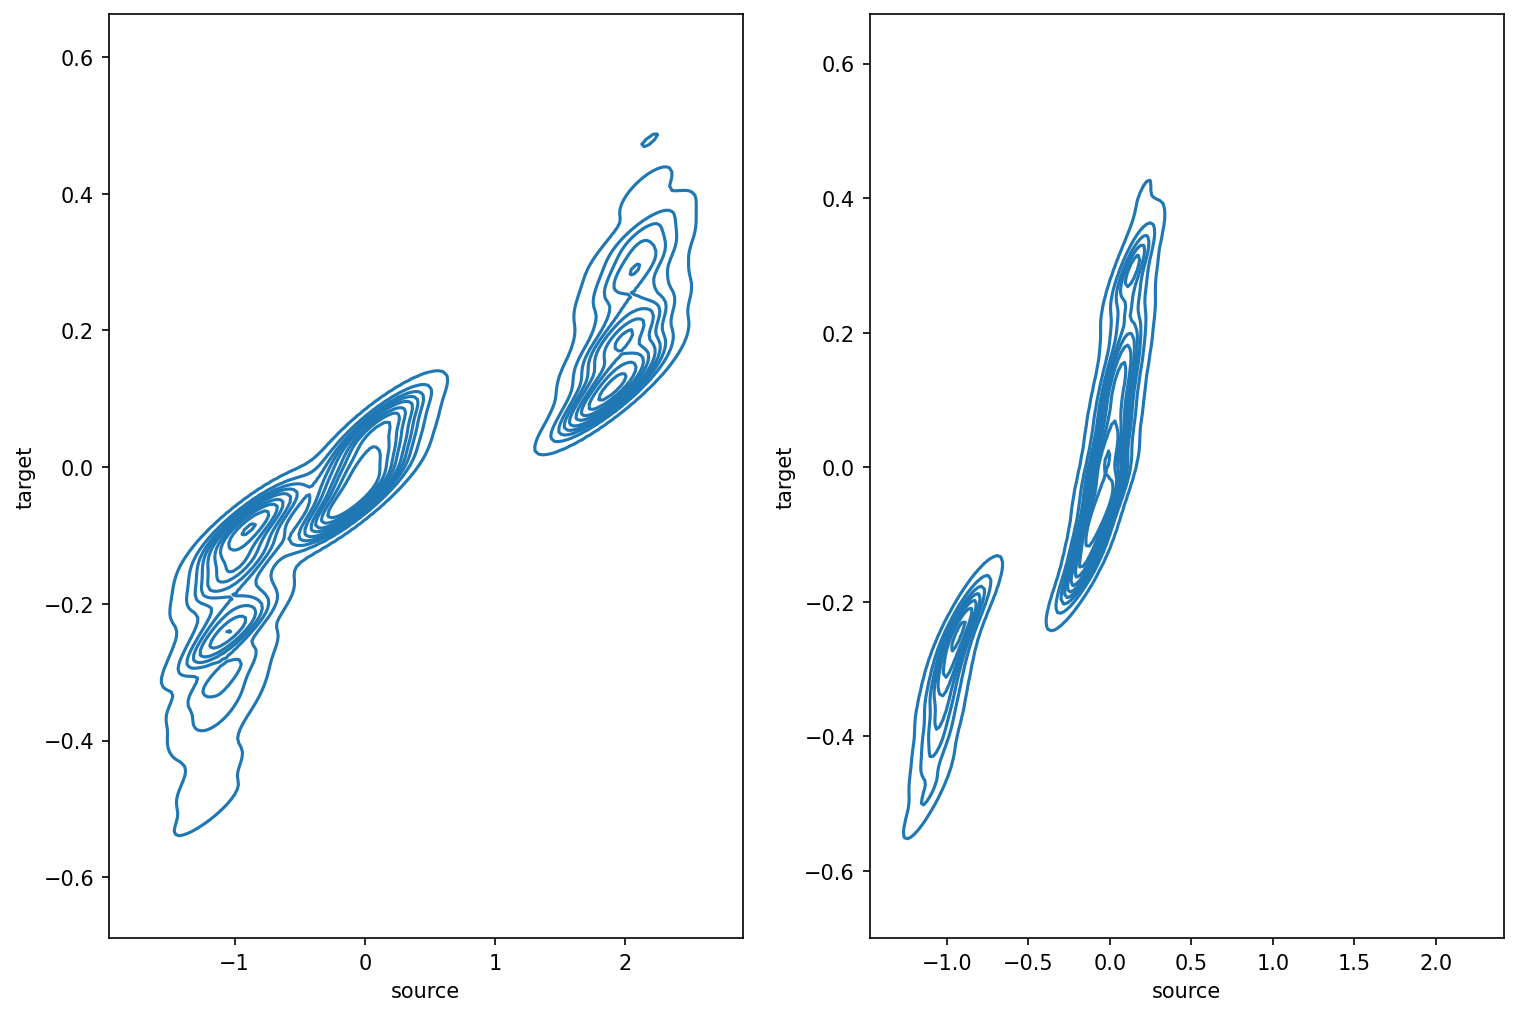

In [13]:
import seaborn as sns

fig, axes = plt.subplots(1,2, figsize=(12, 8), dpi=150)
sns.kdeplot(gt_balanced, x="source", y="target", ax=axes[0], bw_adjust=0.5)
sns.kdeplot(gt_unbalanced, x="source", y="target", ax=axes[1], bw_adjust=0.5)


In [14]:
from entot.models.utils import MLP
import flax.linen as nn

mlp_eta = Simple_MLP([64, 64, 64], nn.selu, 1, nn.relu)
mlp_xi = Simple_MLP([64, 64, 64], nn.selu, 1, nn.relu)
unbalanced_kwargs= {"tau_a": 0.998, "tau_b": 0.998, "epsilon": 1e-3, "model": 0}

In [15]:
callback_kwargs={"00_xlim": (-3,3), "01_xlim": (-3,3), "02_xlim": (-3,3), "bw_adjust": 0.4}

In [16]:
kg = KantorovichGapModel(epsilon=1e-3, input_dim=[1], callback=plot_1D_unbalanced, k_noise_per_x=1, iterations=2000, callback_iters=100, mlp_eta=mlp_eta, mlp_xi=mlp_xi, unbalanced_kwargs=unbalanced_kwargs, callback_kwargs=callback_kwargs)

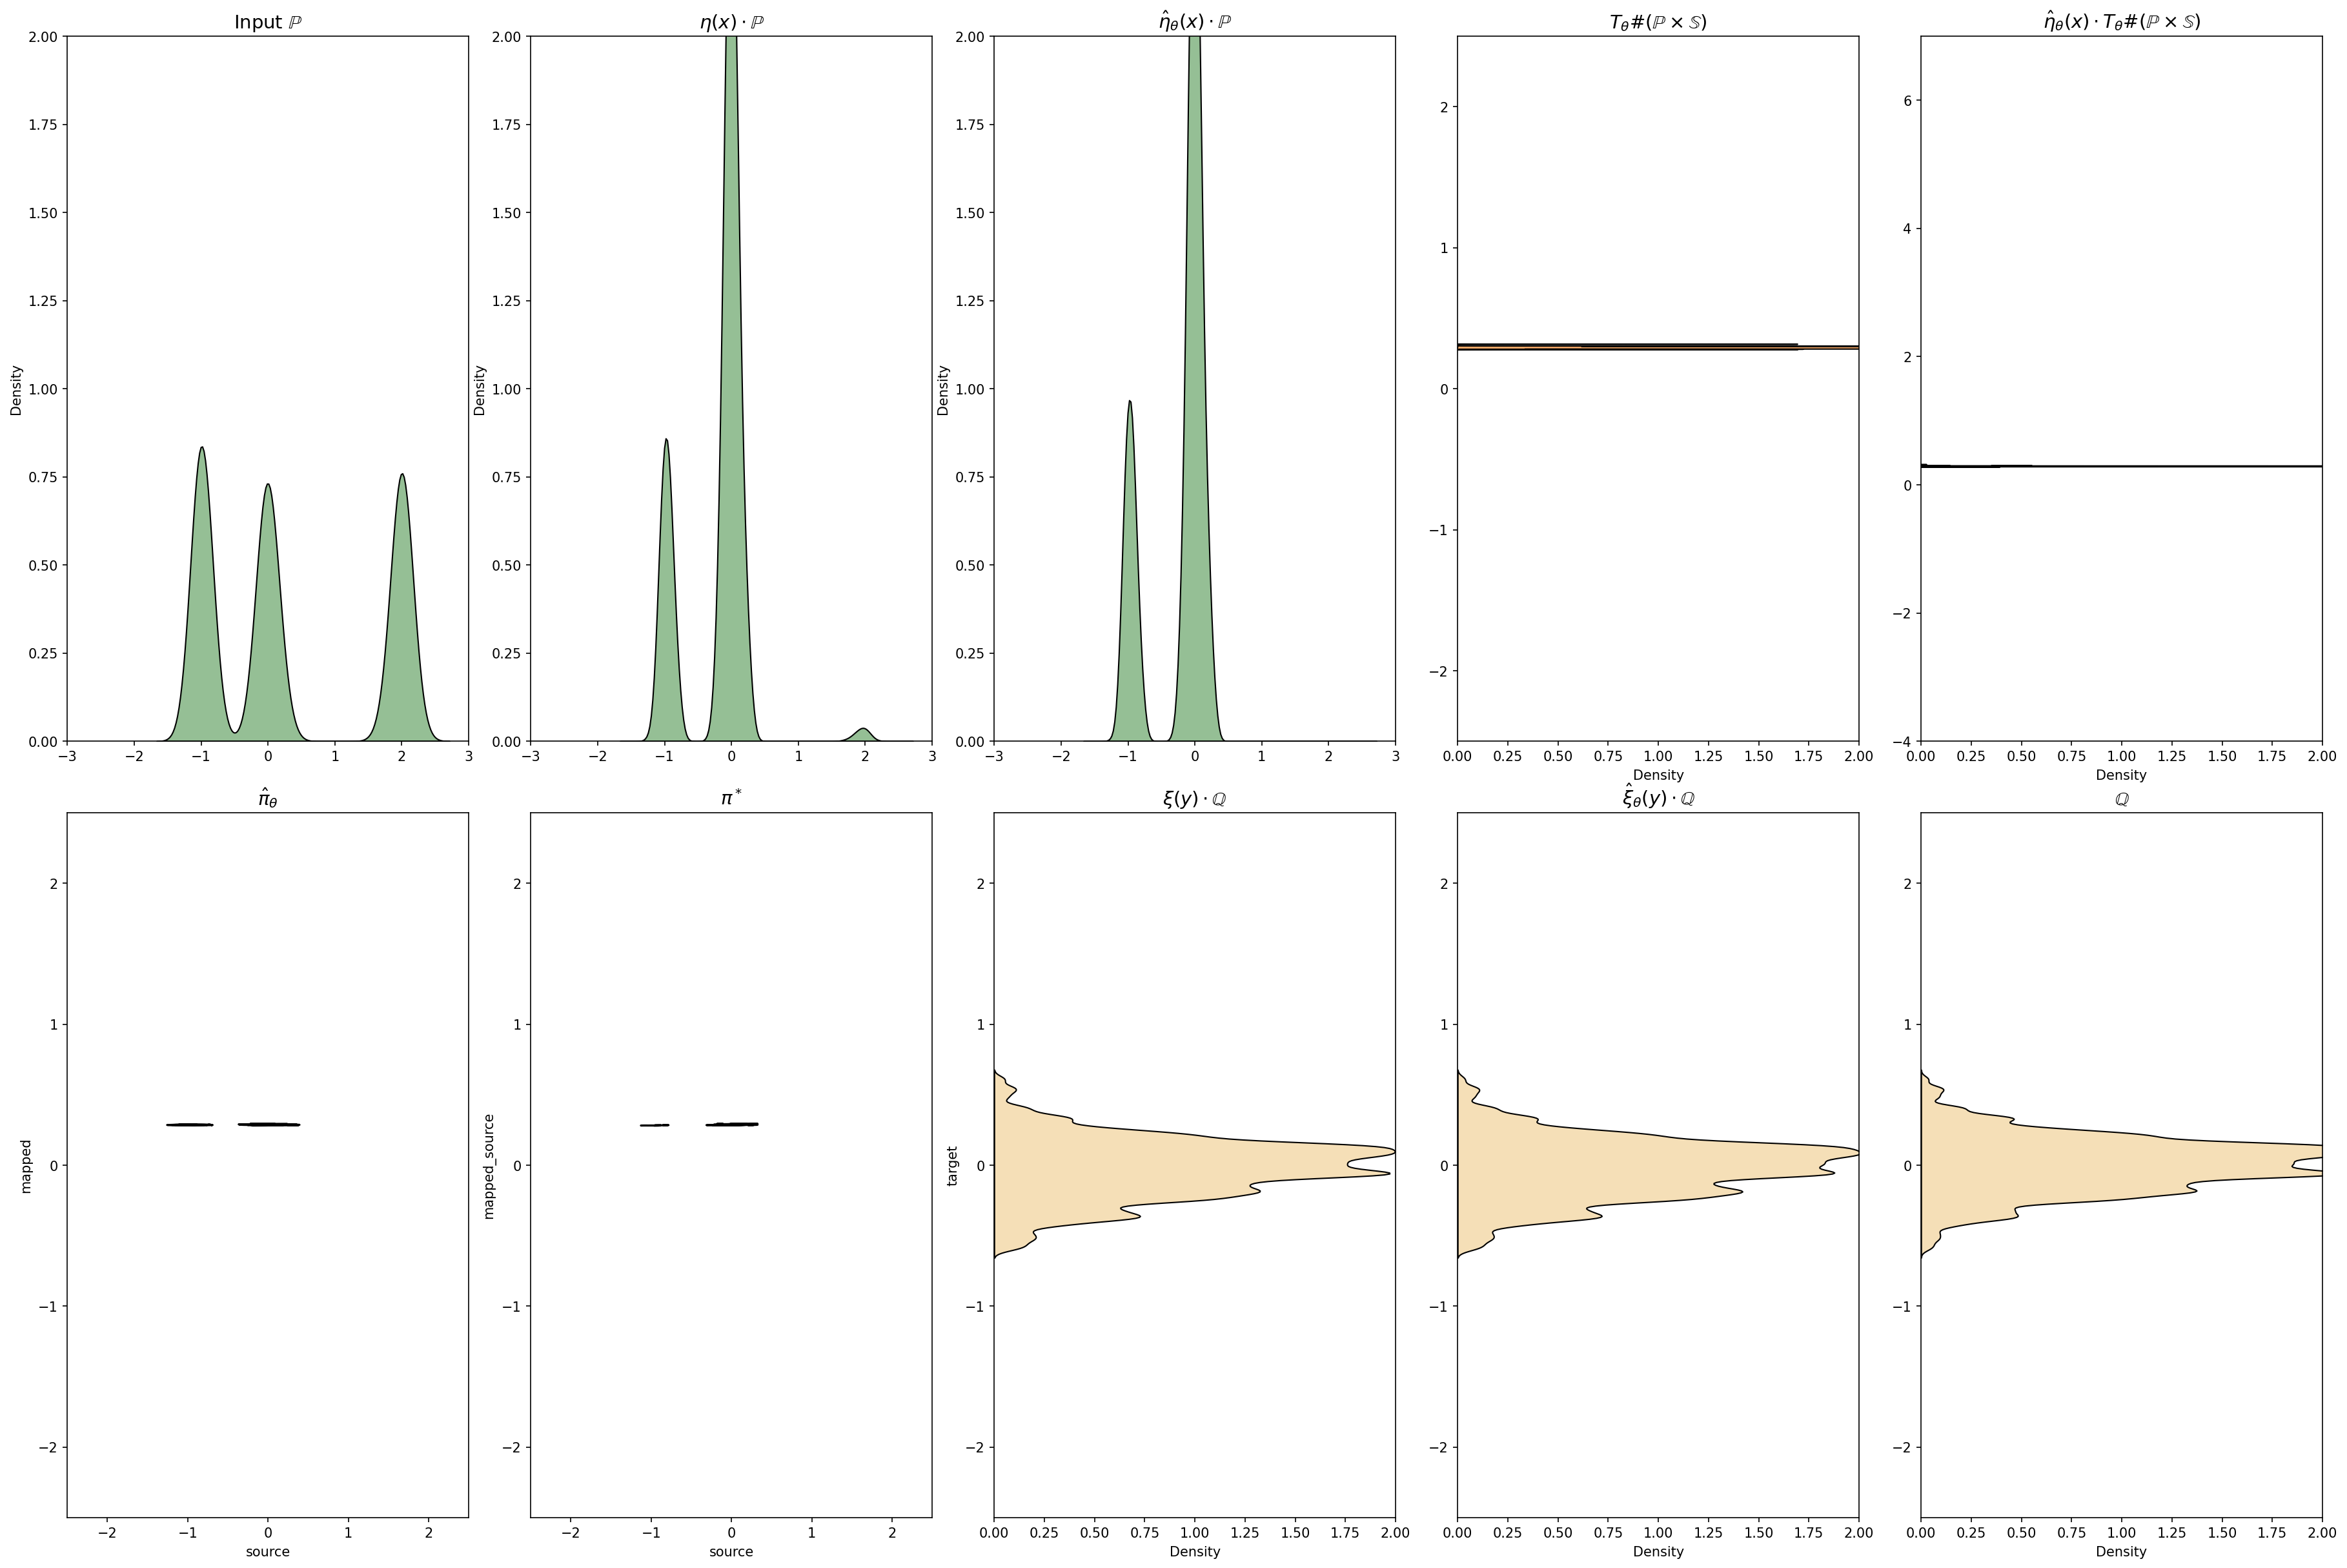

 37%|███▋      | 736/2000 [08:16<12:11,  1.73it/s]

In [17]:
kg(sampler_source, sampler_target)

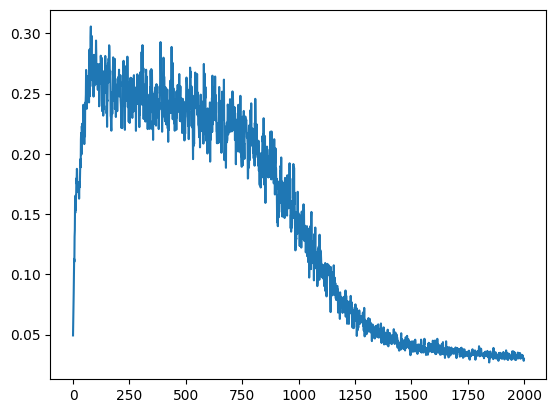

In [18]:
plt.plot(np.arange(len(kg.metrics["kant_gap"])), kg.metrics["kant_gap"])

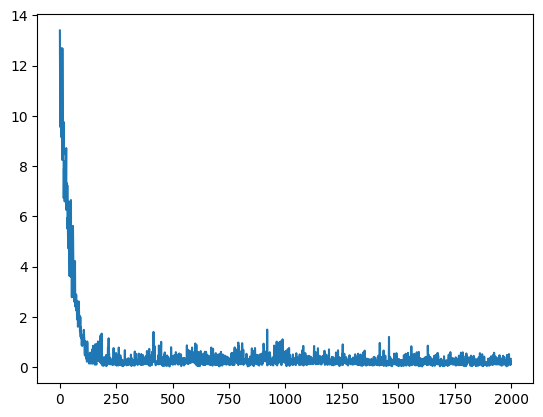

In [19]:
plt.plot(np.arange(len(kg.metrics["fitting_loss"])), kg.metrics["fitting_loss"])

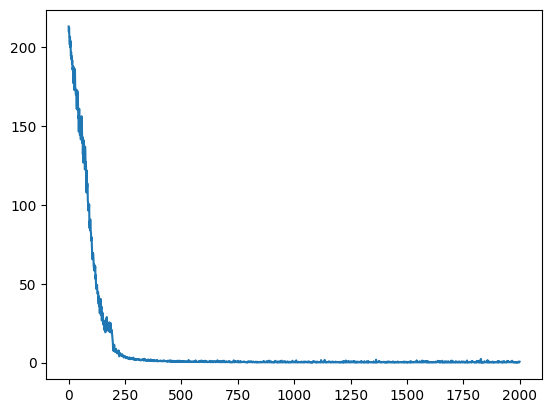

In [20]:
plt.plot(np.arange(len(kg.metrics["fitting_loss"])), kg.metrics["loss_eta"])

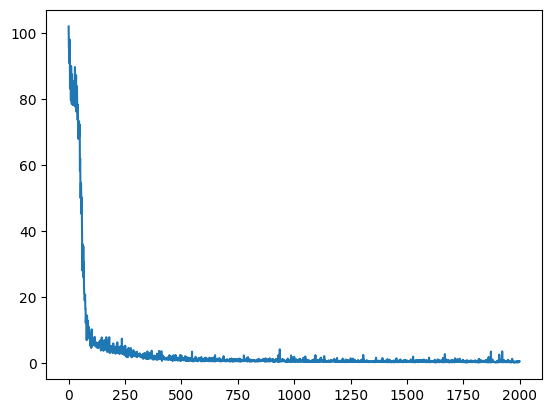

In [21]:
plt.plot(np.arange(len(kg.metrics["fitting_loss"])), kg.metrics["loss_xi"])

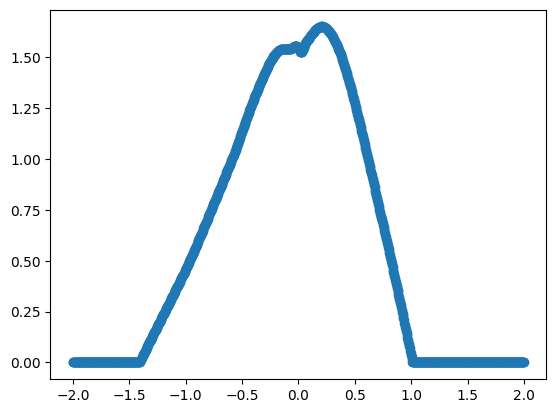

In [22]:
x = jnp.linspace(-2, 2, num=1000)[:, None]
res = kg.state_eta.apply_fn({"params": kg.state_eta.params}, x)
plt.scatter(x, res)

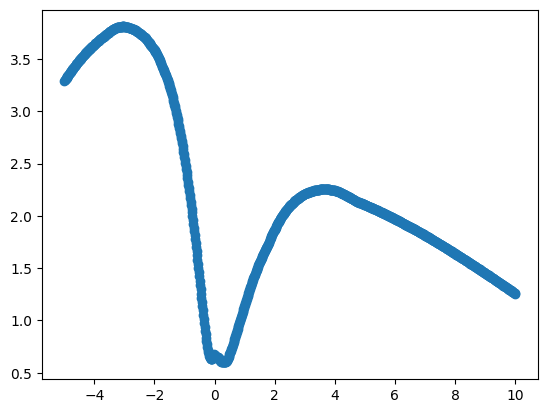

In [23]:
x = jnp.linspace(-5, 10, num=1000)[:, None]
res = kg.state_xi.apply_fn({"params": kg.state_xi.params}, x)
plt.scatter(x, res)